> **Problem overview**

The sinking of the RMS Titanic is one of the most infamous shipwrecks in history.  On April 15, 1912, during her maiden voyage, the Titanic sank after colliding with an iceberg, killing 1502 out of 2224 passengers and crew. This sensational tragedy shocked the international community and led to better safety regulations for ships.

One of the reasons that the shipwreck led to such loss of life was that there were not enough lifeboats for the passengers and crew. Although there was some element of luck involved in surviving the sinking, some groups of people were more likely to survive than others, such as women, children, and the upper-class.

In this challenge, we ask you to complete the analysis of what sorts of people were likely to survive. In particular, we ask you to apply the tools of machine learning to predict which passengers survived the tragedy.

In [1]:
# import python standard library
import re

# import data manipulation library
import numpy as np
import pandas as pd

# import data visualization library
import matplotlib.pyplot as plt
import seaborn as sns

# import sklearn model class
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

# import sklearn model selection
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

# import sklearn model evaluation classification metrics
from sklearn.metrics import accuracy_score, auc, classification_report, confusion_matrix, f1_score, fbeta_score, precision_recall_curve, precision_score, recall_score, roc_auc_score, roc_curve

> **Acquiring training and testing data**

We start by acquiring the training and testing datasets into Pandas DataFrames.

In [2]:
# acquiring training and testing data
df_train = pd.read_csv('../input/train.csv')
df_test = pd.read_csv('../input/test.csv')

In [3]:
# visualize head of the training data
df_train.head(n=5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
# visualize tail of the testing data
df_test.tail(n=5)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
413,1305,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,NaN,S
414,1306,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,C
415,1307,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S
416,1308,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.0500,NaN,S
417,1309,3,"Peter, Master. Michael J",male,NaN,1,1,2668,22.3583,NaN,C


In [5]:
# combine training and testing dataframe
df_train['DataType'], df_test['DataType'] = 'training', 'testing'
df_test.insert(1, 'Survived', np.nan)
df_data = pd.concat([df_train, df_test], ignore_index=True)

> **Feature exploration, engineering and cleansing**

Here we generate descriptive statistics that summarize the central tendency, dispersion and shape of a dataset’s distribution together with exploring some data.

In [6]:
def countplot(categorical_x: list or str, categorical_y: list or str, data: pd.DataFrame, figsize: tuple = (4, 3), ncols: int = 5, nrows: int = None) -> plt.figure:
    """ Return a count plot applied for categorical variable in x-axis vs categorical variable in y-axis.
    
    Args:
        categorical_x (list or str): The categorical variable in x-axis.
        categorical_y (list or str): The categorical variable in y-axis.
        data (pd.DataFrame): The data to plot.
        figsize (tuple): The matplotlib figure size width and height in inches. Default to (4, 3).
        ncols (int): The number of columns for axis in the figure. Default to 5.
        nrows (int): The number of rows for axis in the figure. Default to None.
    
    Returns:
        plt.figure: The plot figure.
    """
    
    categorical_x, categorical_y = [categorical_x] if type(categorical_x) == str else categorical_x, [categorical_y] if type(categorical_y) == str else categorical_y
    if nrows is None: nrows = (len(categorical_x)*len(categorical_y) - 1) // ncols + 1
    
    fig, axes = plt.subplots(figsize=(figsize[0]*ncols , figsize[1]*nrows), ncols=ncols, nrows=nrows)
    axes = axes.flatten()
    _ = [sns.countplot(x=vj, hue=vi, data=data, ax=axes[i*len(categorical_x) + j], rasterized=True) for i, vi in enumerate(categorical_y) for j, vj in enumerate(categorical_x)]
    return fig

In [7]:
def swarmplot(categorical_x: list or str, numerical_y: list or str, data: pd.DataFrame, figsize: tuple = (4, 3), ncols: int = 5, nrows: int = None) -> plt.figure:
    """ Return a swarm plot applied for categorical variable in x-axis vs numerical variable in y-axis.
    
    Args:
        categorical_x (list or str): The categorical variable in x-axis.
        numerical_y (list or str): The numerical variable in y-axis.
        data (pd.DataFrame): The data to plot.
        figsize (tuple): The matplotlib figure size width and height in inches. Default to (4, 3).
        ncols (int): The number of columns for axis in the figure. Default to 5.
        nrows (int): The number of rows for axis in the figure. Default to None.
    
    Returns:
        plt.figure: The plot figure.
    """
    
    categorical_x, numerical_y = [categorical_x] if type(categorical_x) == str else categorical_x, [numerical_y] if type(numerical_y) == str else numerical_y
    if nrows is None: nrows = (len(categorical_x)*len(numerical_y) - 1) // ncols + 1
    
    fig, axes = plt.subplots(figsize=(figsize[0]*ncols , figsize[1]*nrows), ncols=ncols, nrows=nrows)
    axes = axes.flatten()
    _ = [sns.swarmplot(x=vj, y=vi, data=data, ax=axes[i*len(categorical_x) + j], rasterized=True) for i, vi in enumerate(numerical_y) for j, vj in enumerate(categorical_x)]
    return fig

In [8]:
def violinplot(categorical_x: list or str, numerical_y: list or str, data: pd.DataFrame, figsize: tuple = (4, 3), ncols: int = 5, nrows: int = None) -> plt.figure:
    """ Return a violin plot applied for categorical variable in x-axis vs numerical variable in y-axis.
    
    Args:
        categorical_x (list or str): The categorical variable in x-axis.
        numerical_y (list or str): The numerical variable in y-axis.
        data (pd.DataFrame): The data to plot.
        figsize (tuple): The matplotlib figure size width and height in inches. Default to (4, 3).
        ncols (int): The number of columns for axis in the figure. Default to 5.
        nrows (int): The number of rows for axis in the figure. Default to None.
    
    Returns:
        plt.figure: The plot figure.
    """
    
    categorical_x, numerical_y = [categorical_x] if type(categorical_x) == str else categorical_x, [numerical_y] if type(numerical_y) == str else numerical_y
    if nrows is None: nrows = (len(categorical_x)*len(numerical_y) - 1) // ncols + 1
    
    fig, axes = plt.subplots(figsize=(figsize[0]*ncols , figsize[1]*nrows), ncols=ncols, nrows=nrows)
    axes = axes.flatten()
    _ = [sns.violinplot(x=vj, y=vi, data=data, ax=axes[i*len(categorical_x) + j], rasterized=True) for i, vi in enumerate(numerical_y) for j, vj in enumerate(categorical_x)]
    return fig

In [9]:
# describe training and testing data
df_data.describe(include='all')

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,DataType
count,1309.000000,891.000000,1309.000000,1309,1309,1046.000000,1309.000000,1309.000000,1309,1308.000000,295,1307,1309
unique,NaN,NaN,NaN,1307,2,NaN,NaN,NaN,929,NaN,186,3,2
top,NaN,NaN,NaN,"Connolly, Miss. Kate",male,NaN,NaN,NaN,CA. 2343,NaN,C23 C25 C27,S,training
freq,NaN,NaN,NaN,2,843,NaN,NaN,NaN,11,NaN,6,914,891
mean,655.000000,0.383838,2.294882,NaN,NaN,29.881138,0.498854,0.385027,NaN,33.295479,NaN,NaN,NaN
std,378.020061,0.486592,0.837836,NaN,NaN,14.413493,1.041658,0.865560,NaN,51.758668,NaN,NaN,NaN
min,1.000000,0.000000,1.000000,NaN,NaN,0.170000,0.000000,0.000000,NaN,0.000000,NaN,NaN,NaN
25%,328.000000,0.000000,2.000000,NaN,NaN,21.000000,0.000000,0.000000,NaN,7.895800,NaN,NaN,NaN
50%,655.000000,0.000000,3.000000,NaN,NaN,28.000000,0.000000,0.000000,NaN,14.454200,NaN,NaN,NaN
75%,982.000000,1.000000,3.000000,NaN,NaN,39.000000,1.000000,0.000000,NaN,31.275000,NaN,NaN,NaN


In [10]:
# convert dtypes numeric to object
col_convert = ['Survived', 'Pclass', 'SibSp', 'Parch']
df_data[col_convert] = df_data[col_convert].astype('object')

In [11]:
# list all features type number
col_number = df_data.select_dtypes(include=['number']).columns.tolist()
print('features type number:\n items %s\n length %d' %(col_number, len(col_number)))

# list all features type object
col_object = df_data.select_dtypes(include=['object']).columns.tolist()
print('features type object:\n items %s\n length %d' %(col_object, len(col_object)))

features type number:
 items ['PassengerId', 'Age', 'Fare']
 length 3
features type object:
 items ['Survived', 'Pclass', 'Name', 'Sex', 'SibSp', 'Parch', 'Ticket', 'Cabin', 'Embarked', 'DataType']
 length 10


In [12]:
# feature extraction: surname
df_data['Surname'] = df_data['Name'].str.extract(r'([A-Za-z]+),', expand=False)

In [13]:
# feature extraction: title
df_data['Title'] = df_data['Name'].str.extract(r' ([A-Za-z]+)\.', expand=False)
df_data['Title'] = df_data['Title'].replace(['Capt', 'Rev'], 'Crew')
df_data['Title'] = df_data['Title'].replace('Ms', 'Miss')
df_data['Title'] = df_data['Title'].replace(['Col', 'Countess', 'Don', 'Dona', 'Jonkheer', 'Lady', 'Major', 'Mlle', 'Mme', 'Sir'], 'Royal')
df_data['Title'].value_counts()

Mr        757
Miss      262
Mrs       197
Master     61
Royal      15
Crew        9
Dr          8
Name: Title, dtype: int64

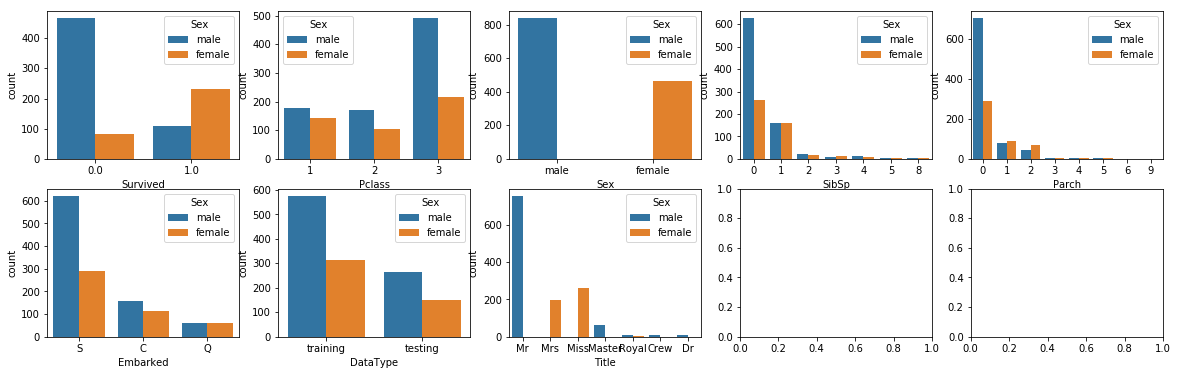

In [14]:
# feature exploration: sex
col_object = df_data.select_dtypes(include=['object']).columns.drop(['Name', 'Ticket', 'Cabin', 'Surname']).tolist()
_ = countplot(col_object, 'Sex', df_data)

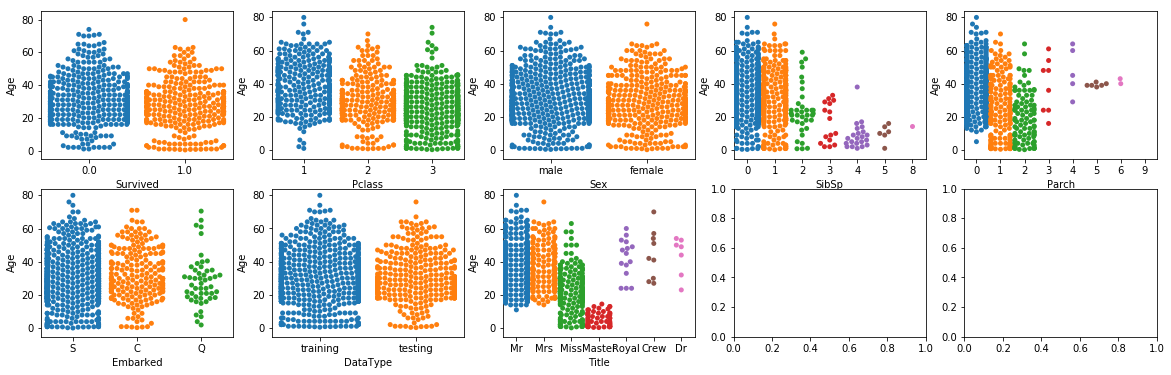

In [15]:
# feature exploration: age
col_object = df_data.select_dtypes(include=['object']).columns.drop(['Name', 'Ticket', 'Cabin', 'Surname']).tolist()
_ = swarmplot(col_object, 'Age', df_data)

In [16]:
# feature extraction: age
df_data['Age'] = df_data['Age'].fillna(df_data.groupby(['Title'], as_index=True)['Age'].transform('mean'))

In [17]:
# feature extraction: family size
df_data['FamilySize'] = df_data['SibSp'] + df_data['Parch'] + 1

In [18]:
# feature extraction: ticket string
df_data['TicketString'] = df_data['Ticket'].apply(lambda x: ''.join(re.findall(r'[a-zA-Z]+', x)))
df_data['TicketString'] = df_data['TicketString'].replace(['CASOTON', 'SOTONO', 'STONO', 'STONOQ'], 'SOTONOQ')
df_data['TicketString'] = df_data['TicketString'].replace(['SC', 'SCParis'], 'SCPARIS')
df_data['TicketString'] = df_data['TicketString'].replace('FCC', 'FC')
df_data['TicketString'] = df_data['TicketString'].replace(df_data['TicketString'].value_counts()[df_data['TicketString'].value_counts() < 10].index.tolist(), 'OTHER')
df_data['TicketString'].value_counts()

           957
PC          92
CA          68
OTHER       55
SOTONOQ     50
A           39
SCPARIS     21
WC          15
FC          12
Name: TicketString, dtype: int64

In [19]:
# feature extraction: has ticket string
df_data['HasTicketString'] = df_data['TicketString'].apply(lambda x: 1 if x else 0).astype('object')

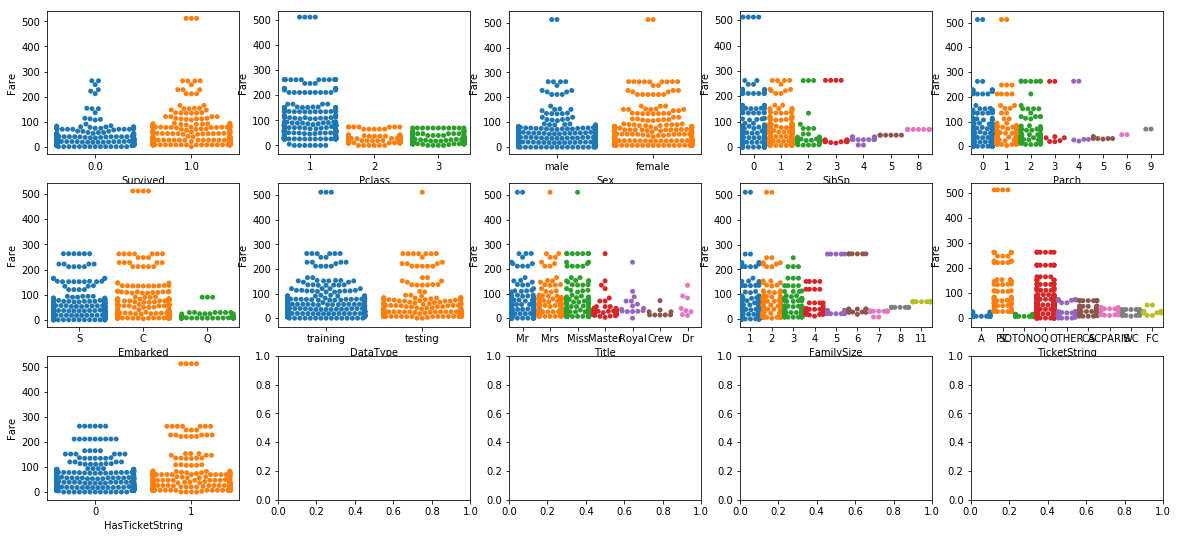

In [20]:
# feature exploration: fare
col_object = df_data.select_dtypes(include=['object']).columns.drop(['Name', 'Ticket', 'Cabin', 'Surname']).tolist()
_ = swarmplot(col_object, 'Fare', df_data)

In [21]:
# feature extraction: fare
df_data['Fare'] = df_data['Fare'].fillna(df_data.groupby(['Pclass'], as_index=True)['Fare'].transform('mean'))

In [22]:
# feature extraction: cabin
df_data['Cabin'] = df_data['Cabin'].fillna(0)

In [23]:
# feature extraction: cabin string
df_data['CabinString'] = df_data['Cabin'].str.extract(r'([A-Za-z]+)', expand=False)

In [24]:
# feature extraction: has cabin
df_data['HasCabin'] = df_data['CabinString'].apply(lambda x: 0 if pd.isnull(x) else 1).astype('object')

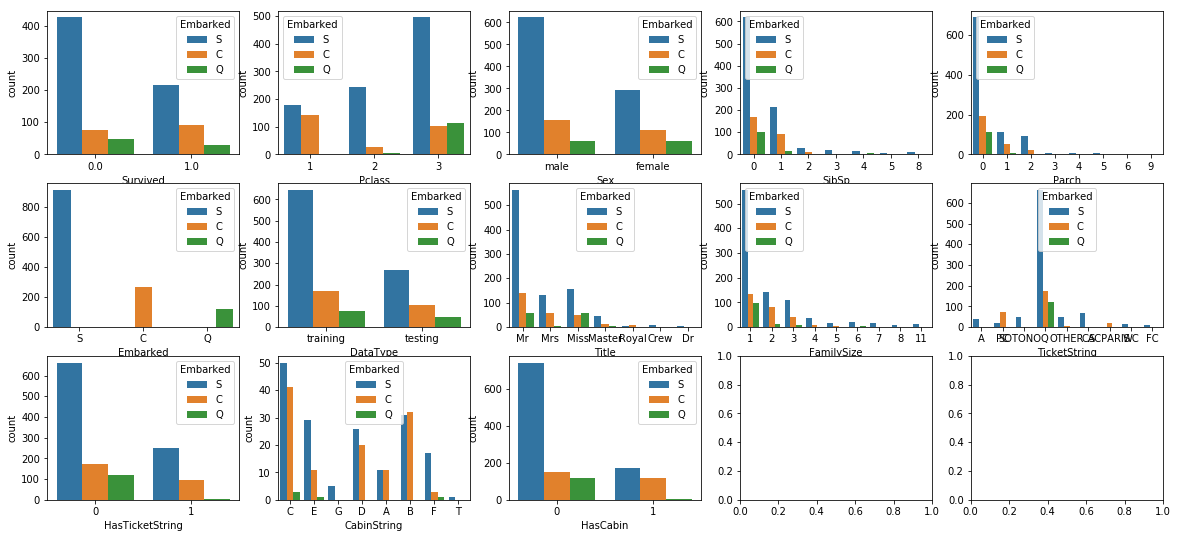

In [25]:
# feature exploration: embarked
col_object = df_data.select_dtypes(include=['object']).columns.drop(['Name', 'Ticket', 'Cabin', 'Surname']).tolist()
_ = countplot(col_object, 'Embarked', df_data)

In [26]:
# feature extraction: embarked
df_data['Embarked'] = df_data['Embarked'].fillna(df_data['Embarked'].value_counts().idxmax())

In [27]:
# list all features type number
col_number = df_data.select_dtypes(include=['number']).columns.tolist()
print('features type number:\n items %s\n length %d' %(col_number, len(col_number)))

# list all features type object
col_object = df_data.select_dtypes(include=['object']).columns.tolist()
print('features type object:\n items %s\n length %d' %(col_object, len(col_object)))

features type number:
 items ['PassengerId', 'Age', 'Fare']
 length 3
features type object:
 items ['Survived', 'Pclass', 'Name', 'Sex', 'SibSp', 'Parch', 'Ticket', 'Cabin', 'Embarked', 'DataType', 'Surname', 'Title', 'FamilySize', 'TicketString', 'HasTicketString', 'CabinString', 'HasCabin']
 length 17


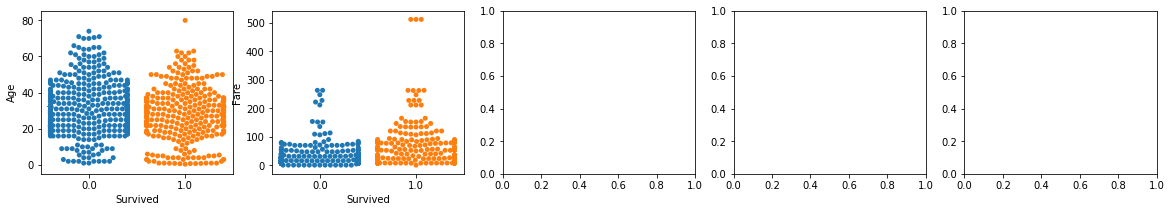

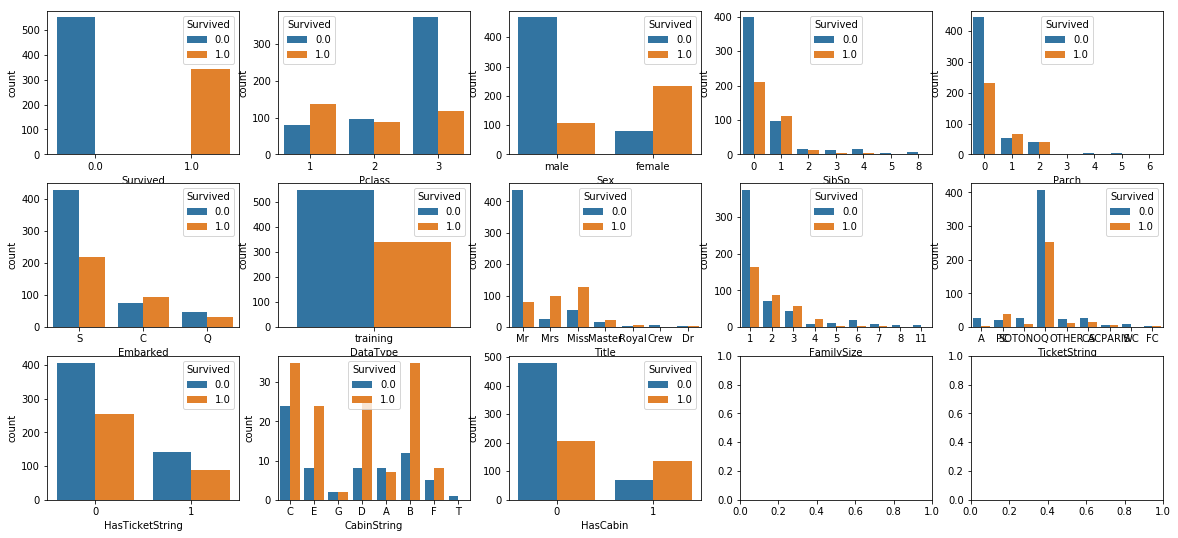

In [28]:
# feature exploration: survived
col_number = df_data.select_dtypes(include=['number']).columns.drop(['PassengerId']).tolist()
col_object = df_data.select_dtypes(include=['object']).columns.drop(['Name', 'Ticket', 'Cabin', 'Surname']).tolist()
_ = swarmplot('Survived', col_number, df_data[df_data['DataType'] == 'training'])
_ = countplot(col_object, 'Survived', df_data[df_data['DataType'] == 'training'])

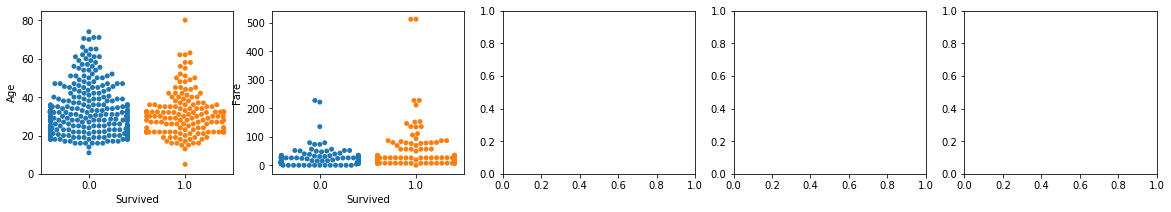

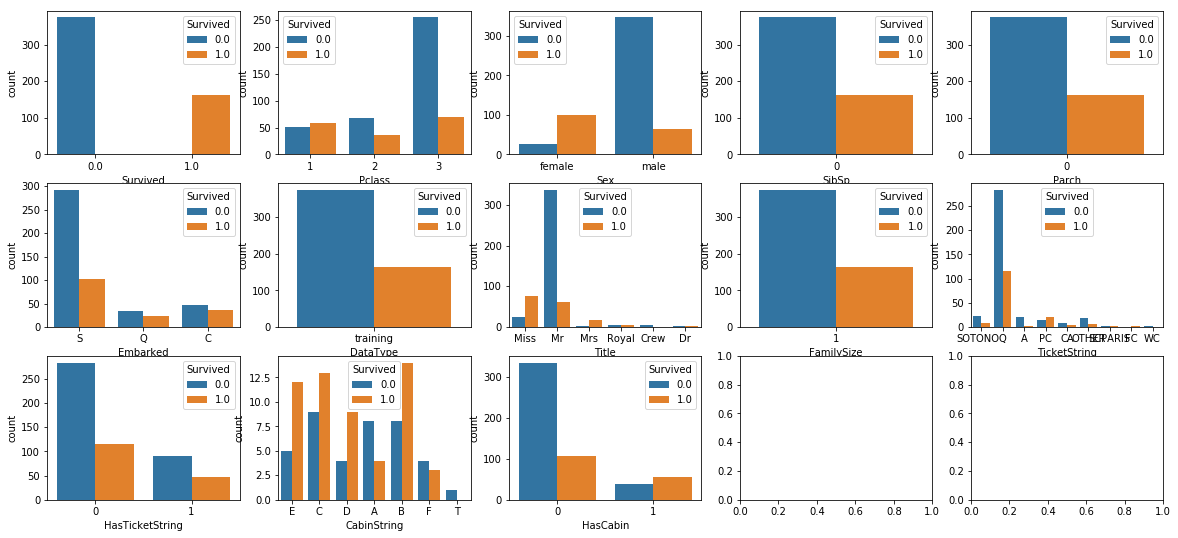

In [29]:
# feature exploration: survived where family size equal to 1
col_number = df_data.select_dtypes(include=['number']).columns.drop(['PassengerId']).tolist()
col_object = df_data.select_dtypes(include=['object']).columns.drop(['Name', 'Ticket', 'Cabin', 'Surname']).tolist()
_ = swarmplot('Survived', col_number, df_data[(df_data['DataType'] == 'training') & (df_data['FamilySize'] == 1)])
_ = countplot(col_object, 'Survived', df_data[(df_data['DataType'] == 'training') & (df_data['FamilySize'] == 1)])

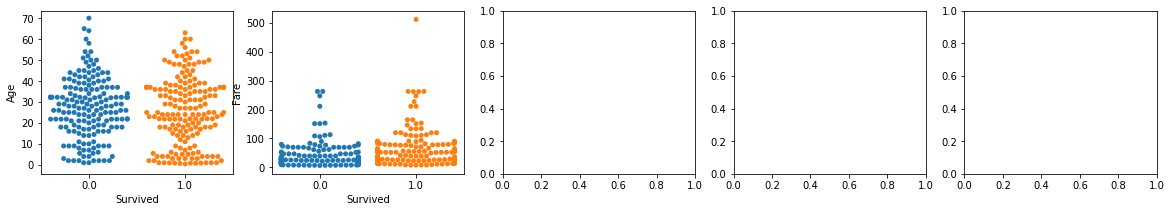

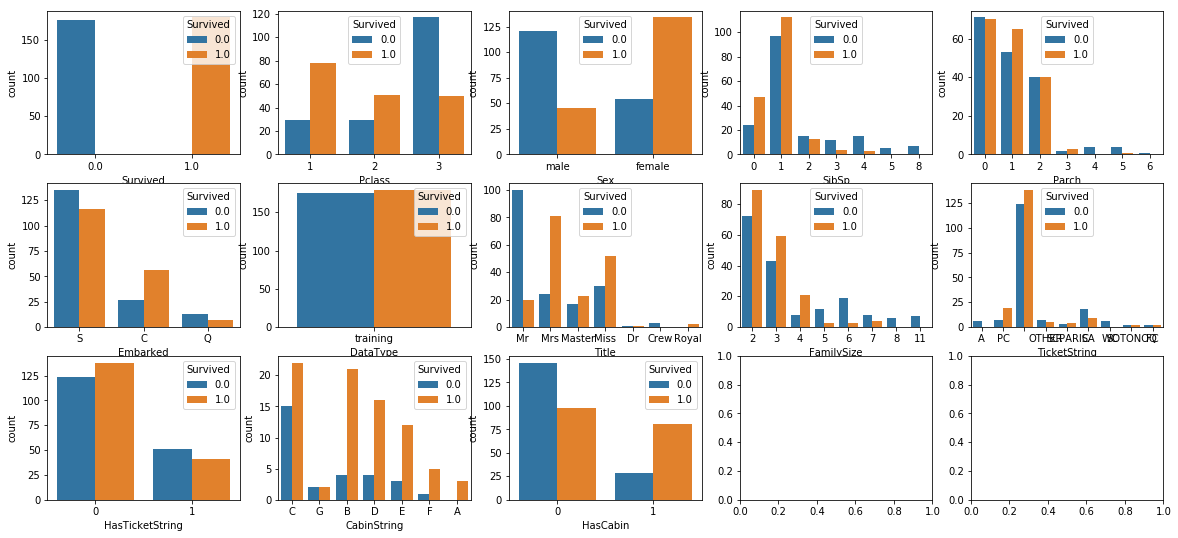

In [30]:
# feature exploration: survived where family size more than 1
col_number = df_data.select_dtypes(include=['number']).columns.drop(['PassengerId']).tolist()
col_object = df_data.select_dtypes(include=['object']).columns.drop(['Name', 'Ticket', 'Cabin', 'Surname']).tolist()
_ = swarmplot('Survived', col_number, df_data[(df_data['DataType'] == 'training') & (df_data['FamilySize'] > 1)])
_ = countplot(col_object, 'Survived', df_data[(df_data['DataType'] == 'training') & (df_data['FamilySize'] > 1)])

The exploratory data analysis resulting in,
* **Pclass:** The 1st class ticket tend to more survived than 2nd class and 3rd class, respectively.
* **Sex:** Female tend to more survived than male.
* **Title:** The master and royal title tend to more survived than other male titles.
* **FamilySize:** The persons who come with family tend to more survived than single.
* **CabinString:** The persons assigned cabin A to F except C tend to more survived than cabin C and G, respectively.
* **HasCabin:** The persons assigned cabin tend to more survived than without assgned cabin.

In [31]:
# feature extraction: ticket dataframe
df_ticket = pd.get_dummies(df_data[df_data['FamilySize'] > 1], columns=['Pclass', 'Sex', 'Embarked', 'DataType', 'Title', 'CabinString', 'HasCabin'], drop_first=False)
df_ticket['Survived'] = df_ticket['Survived'].astype(float)
df_ticket = df_ticket.groupby(['Ticket'], as_index=False).agg({
    'Survived': 'mean',
    'Pclass_1': sum, 'Pclass_2': sum,  'Pclass_3': sum,
    'Sex_male': sum, 'Sex_female': sum,
    'Embarked_C': sum, 'Embarked_Q': sum, 'Embarked_S': sum,
    'DataType_training': sum, 'DataType_testing': sum,
    'Title_Crew': sum, 'Title_Dr': sum, 'Title_Master': sum, 'Title_Miss': sum, 'Title_Mr': sum, 'Title_Mrs': sum, 'Title_Royal': sum,
    'CabinString_A': sum, 'CabinString_B': sum, 'CabinString_C': sum, 'CabinString_D': sum, 'CabinString_E': sum, 'CabinString_F': sum, 'CabinString_G': sum,
    'HasCabin_0': sum, 'HasCabin_1': sum
})

In [32]:
# describe ticket dataframe
df_ticket.describe(include='all')

,Ticket,Survived,Pclass_1,Pclass_2,Pclass_3,Sex_male,Sex_female,Embarked_C,Embarked_Q,Embarked_S,DataType_training,DataType_testing,Title_Crew,Title_Dr,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Royal,CabinString_A,CabinString_B,CabinString_C,CabinString_D,CabinString_E,CabinString_F,CabinString_G,HasCabin_0,HasCabin_1
count,230,198.000000,230.000000,230.000000,230.000000,230.000000,230.000000,230.000000,230.000000,230.000000,230.000000,230.000000,230.000000,230.000000,230.000000,230.000000,230.000000,230.000000,230.000000,230.000000,230.000000,230.00000,230.000000,230.000000,230.000000,230.000000,230.000000,230.000000
unique,230,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,2668,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,0.528199,0.708696,0.517391,1.030435,1.073913,1.182609,0.586957,0.108696,1.560870,1.539130,0.717391,0.017391,0.013043,0.260870,0.478261,0.773913,0.700000,0.013043,0.021739,0.165217,0.26087,0.117391,0.091304,0.034783,0.021739,1.543478,0.713043
std,NaN,0.448816,1.120439,1.013943,1.627797,0.885949,0.892302,1.044346,0.569542,1.597826,1.187908,0.766750,0.131009,0.113708,0.675031,0.751683,0.620760,0.495834,0.113708,0.218083,0.639738,0.78842,0.475745,0.462963,0.335145,0.237263,1.592923,1.138951
min,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,NaN,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,NaN,0.500000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,2.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
75%,NaN,1.000000,2.000000,0.000000,2.000000,1.000000,2.000000,1.000000,0.000000,2.000000,2.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,2.000000,2.000000


In [33]:
# convert dtypes numeric to object
col_convert = df_ticket.columns.drop('Ticket').tolist()
df_ticket[col_convert] = df_ticket[col_convert].astype('object')

In [34]:
# convert dtypes object to numeric
col_convert = ['Survived']
df_ticket[col_convert] = df_ticket[col_convert].astype(float)

In [35]:
# feature extraction: together
df_ticket['Together'] = df_ticket['Survived'].apply(lambda x: 1 if x == 0 or x == 1 else 0).astype('object')

/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


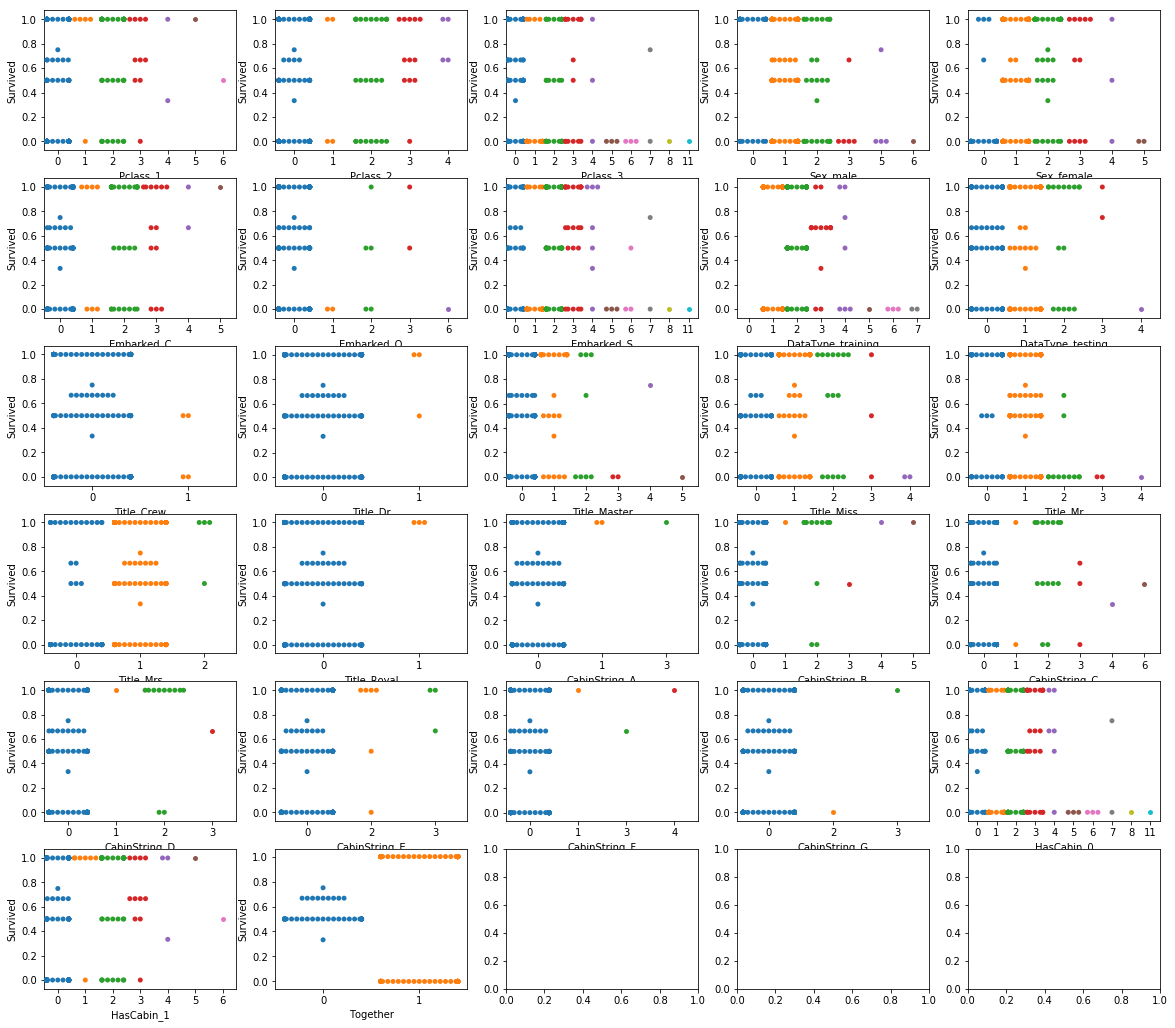

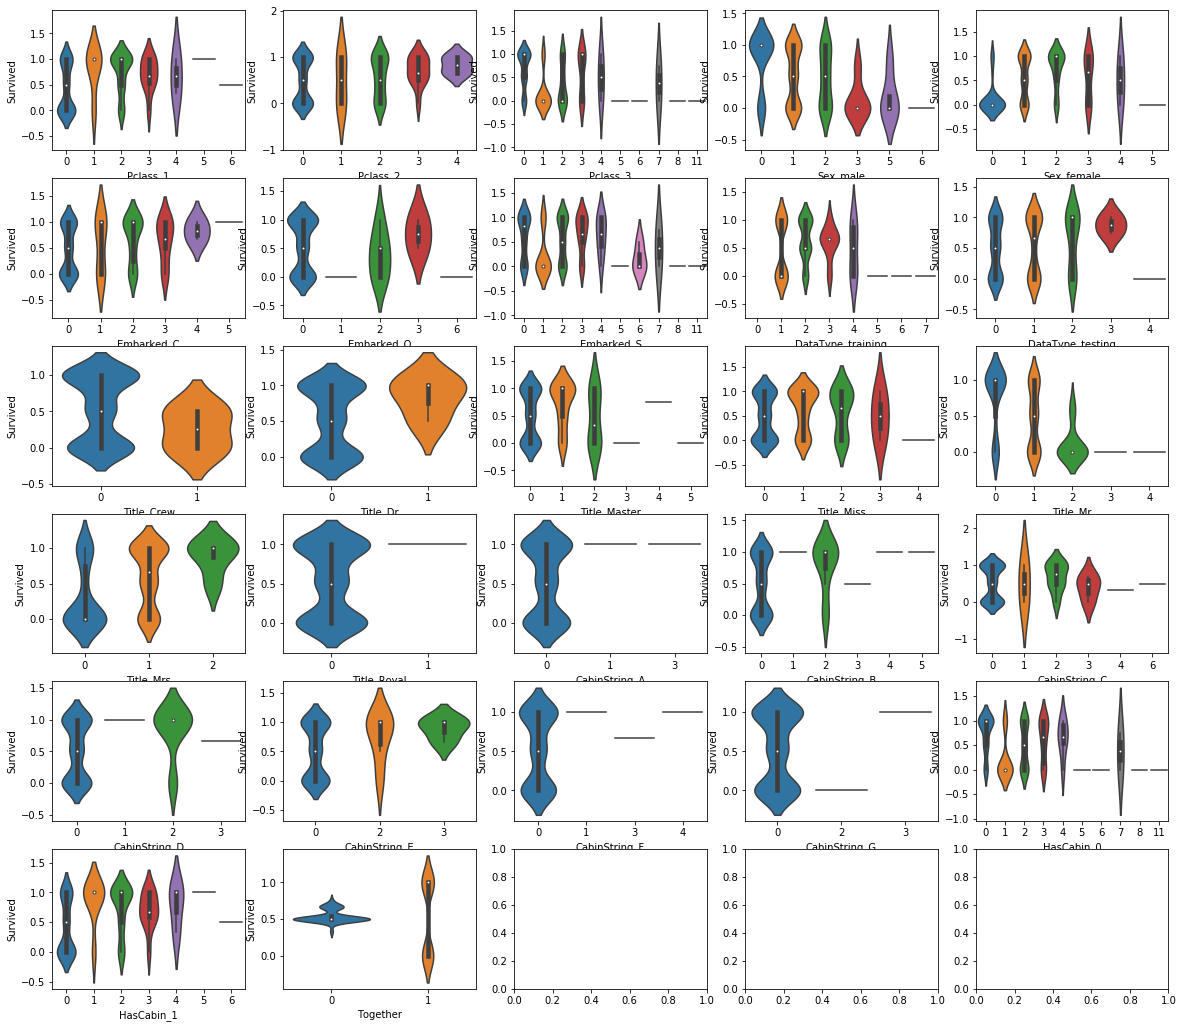

In [36]:
# feature exploration: survived
col_object = df_ticket.select_dtypes(include=['object']).columns.drop('Ticket').tolist()
_ = swarmplot(col_object, 'Survived', df_ticket)
_ = violinplot(col_object, 'Survived', df_ticket)

In [37]:
# feature extraction: with sex and title
df_data = pd.merge(df_data, df_ticket[['Ticket', 'Sex_male', 'Sex_female', 'Title_Crew', 'Title_Dr', 'Title_Master', 'Title_Miss', 'Title_Mr', 'Title_Mrs', 'Title_Royal']], how='left', left_on='Ticket', right_on='Ticket').rename(columns={
    'Sex_male': 'WithSexMale', 'Sex_female': 'WithSexFemale',
    'Title_Crew': 'WithTitleCrew', 'Title_Dr': 'WithTitleDr', 'Title_Master': 'WithTitleMaster', 'Title_Miss': 'WithTitleMiss', 'Title_Mr': 'WithTitleMr', 'Title_Mrs': 'WithTitleMrs', 'Title_Royal': 'WithTitleRoyal'
})
col_fillnas = ['WithSexMale', 'WithSexFemale', 'WithTitleCrew', 'WithTitleDr', 'WithTitleMaster', 'WithTitleMiss', 'WithTitleMr', 'WithTitleMrs', 'WithTitleRoyal']
for col_fillna in col_fillnas: df_data[col_fillna] = df_data[col_fillna].fillna(0)

In [38]:
# feature extraction: ticket_self dataframe
df_temp = df_data.copy(deep=True)
df_temp['Survived'] = df_temp['Survived'].astype(float)
df_ticket_self = df_temp.groupby(['Ticket'], as_index=True)

# feature extraction: survived peer
count = df_ticket_self['Survived'].transform('count')
mean = df_ticket_self['Survived'].transform('mean')
df_data['SurvivedPeer'] = (mean * count - df_data['Survived'].astype(float)) / (count - 1)
df_data['SurvivedPeer'] = df_data['SurvivedPeer'].astype(float).fillna(-1)

In [39]:
# feature extraction: ticket_title dataframe
df_temp = df_data.copy(deep=True)
df_temp['Survived'] = df_temp['Survived'].astype(float)
col_revises = ['Crew', 'Dr', 'Master', 'Miss', 'Mr', 'Mrs', 'Royal']
for col_revise in col_revises:
    df_temp['Survived' + col_revise] = df_temp['Survived']
    df_temp.loc[df_temp['Title'] != col_revise, 'Survived' + col_revise] = np.nan
df_ticket_title = df_temp.groupby(['Ticket'], as_index=True)

# feature extraction: survived peer title
for col_revise in col_revises:
    count = df_ticket_title['Survived' + col_revise].transform('count')
    mean = df_ticket_title['Survived' + col_revise].transform('mean')
    df_data['SurvivedPeer' + col_revise] = (mean * count - df_temp['Survived' + col_revise].astype(float)) / (count - 1)
    df_data['SurvivedPeer' + col_revise] = df_data['SurvivedPeer' + col_revise].astype(float).fillna(-1)

/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


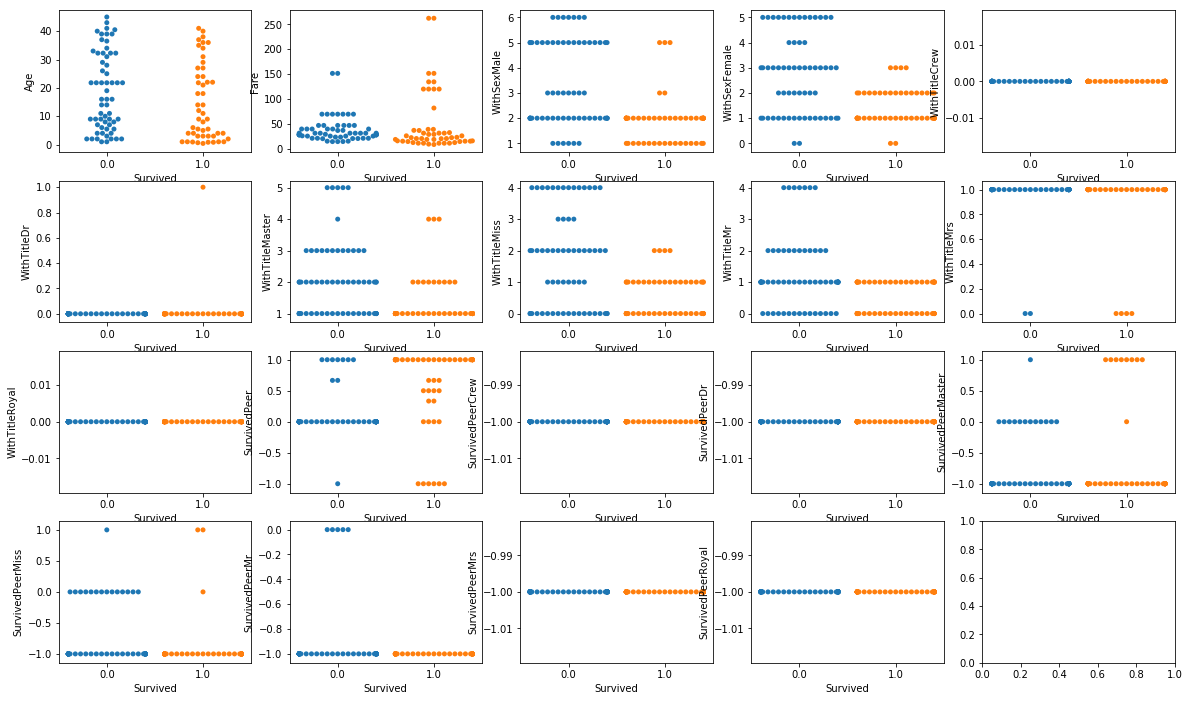

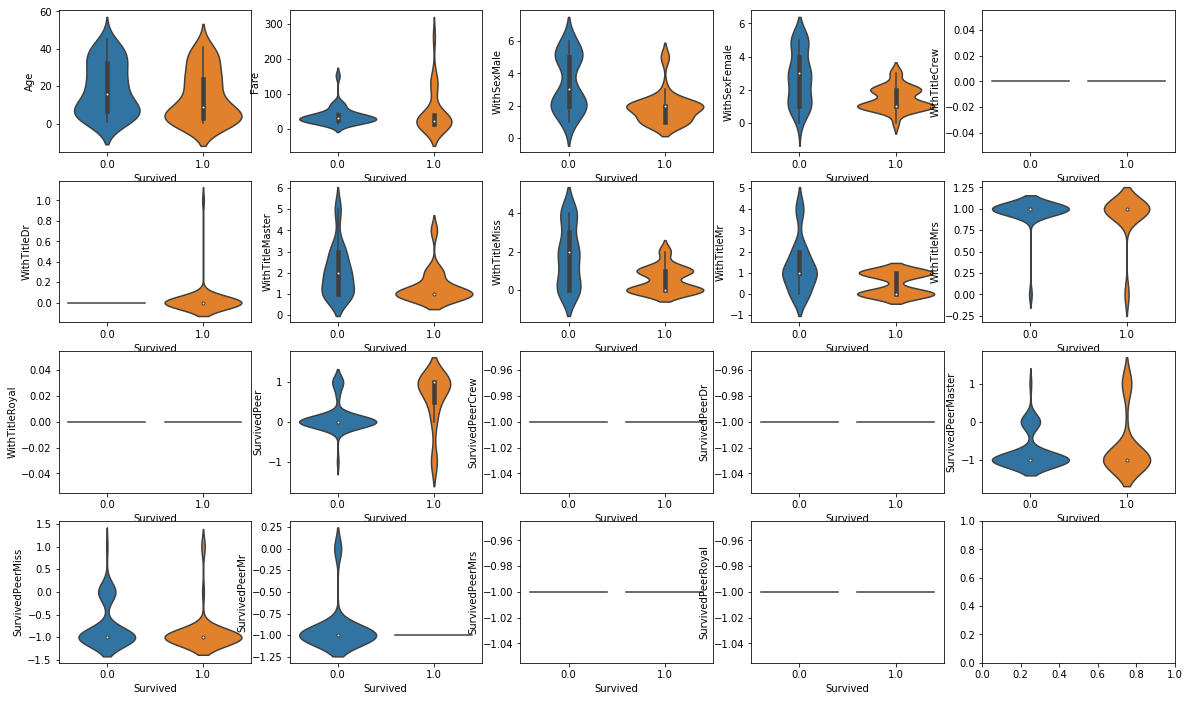

In [40]:
# feature exploration: survived peer and with sex and title
col_number = df_data.select_dtypes(include=['number']).columns.drop(['PassengerId']).tolist()
_ = swarmplot('Survived', col_number, df_data[(df_data['DataType'] == 'training') & (df_data['WithTitleMaster'] >= 1)])
_ = violinplot('Survived', col_number, df_data[(df_data['DataType'] == 'training') & (df_data['WithTitleMaster'] >= 1)])

The exploratory data analysis resulting in,
* **SurvivedPeer:** The survived peer tend to correlated with the survived status.
* **SurvivedPeerMaster:** The survived peer tend to correlated with the survived status for the persons who has master title.
* **SurvivedPeerMiss:** The survived peer tend to correlated with the survived status for the persons who has miss title.
* **SurvivedPeerMr:** The survived peer tend to correlated with the survived status for the persons who has mr title.

After extracting all features, it is required to convert category features to numerics features, a format suitable to feed into our Machine Learning models.

In [41]:
# feature extraction: survived
df_data['Survived'] = df_data['Survived'].fillna(-1)

In [42]:
# convert category codes for data dataframe
df_data = pd.get_dummies(df_data, columns=['Pclass', 'Sex', 'Embarked', 'DataType', 'Title', 'TicketString', 'HasTicketString', 'CabinString', 'HasCabin'], drop_first=True)

In [43]:
# convert dtypes object to numeric for data dataframe
col_convert = ['Survived', 'SibSp', 'Parch', 'FamilySize']
df_data[col_convert] = df_data[col_convert].astype(int)

In [44]:
# describe data dataframe
df_data.describe(include='all')

,PassengerId,Survived,Name,Age,SibSp,Parch,Ticket,Fare,Cabin,Surname,FamilySize,WithSexMale,WithSexFemale,WithTitleCrew,WithTitleDr,WithTitleMaster,WithTitleMiss,WithTitleMr,WithTitleMrs,WithTitleRoyal,SurvivedPeer,SurvivedPeerCrew,SurvivedPeerDr,SurvivedPeerMaster,SurvivedPeerMiss,SurvivedPeerMr,SurvivedPeerMrs,SurvivedPeerRoyal,Pclass_2,Pclass_3,Sex_male,Embarked_Q,Embarked_S,DataType_training,Title_Dr,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Royal,TicketString_A,TicketString_CA,TicketString_FC,TicketString_OTHER,TicketString_PC,TicketString_SCPARIS,TicketString_SOTONOQ,TicketString_WC,HasTicketString_1,CabinString_B,CabinString_C,CabinString_D,CabinString_E,CabinString_F,CabinString_G,CabinString_T,HasCabin_1
count,1309.000000,1309.000000,1309,1309.000000,1309.000000,1309.000000,1309,1309.000000,1309.0,1309,1309.000000,1309.000000,1309.000000,1309.000000,1309.000000,1309.000000,1309.000000,1309.000000,1309.000000,1309.000000,1309.000000,1309.0,1309.0,1309.000000,1309.000000,1309.000000,1309.000000,1309.000000,1309.000000,1309.000000,1309.000000,1309.000000,1309.000000,1309.000000,1309.000000,1309.000000,1309.000000,1309.000000,1309.000000,1309.000000,1309.000000,1309.000000,1309.000000,1309.000000,1309.000000,1309.000000,1309.000000,1309.000000,1309.000000,1309.000000,1309.000000,1309.000000,1309.000000,1309.000000,1309.000000,1309.000000,1309.000000
unique,NaN,NaN,1307,NaN,NaN,NaN,929,NaN,187.0,872,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,NaN,"Connolly, Miss. Kate",NaN,NaN,NaN,CA. 2343,NaN,0.0,Andersson,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,NaN,2,NaN,NaN,NaN,11,NaN,1014.0,11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,655.000000,-0.058060,NaN,29.893288,0.498854,0.385027,NaN,33.280206,NaN,NaN,1.883881,0.617265,0.650879,0.006875,0.006112,0.211612,0.300993,0.387319,0.349121,0.006112,-0.600458,-1.0,-1.0,-0.976318,-0.945760,-0.948052,-0.996944,-0.996944,0.211612,0.541635,0.644003,0.093965,0.699771,0.680672,0.006112,0.046600,0.200153,0.578304,0.150497,0.011459,0.029794,0.051948,0.009167,0.042017,0.070283,0.016043,0.038197,0.011459,0.268908,0.049656,0.071811,0.035141,0.031322,0.016043,0.003820,0.000764,0.225363
std,378.020061,0.760044,NaN,13.194903,1.041658,0.865560,NaN,51.741830,NaN,NaN,1.583639,1.089023,1.042467,0.082665,0.077967,0.669556,0.736452,0.677641,0.492646,0.077967,0.710454,0.0,0.0,0.192095,0.301815,0.257030,0.078146,0.078146,0.408607,0.498454,0.478997,0.291891,0.458533,0.466394,0.077967,0.210862,0.400267,0.494019,0.357694,0.106473,0.170083,0.222007,0.095343,0.200704,0.255720,0.125688,0.191745,0.106473,0.443561,0.217317,0.258273,0.184207,0.174252,0.125688,0.061709,0.027639,0.417981
min,1.000000,-1.000000,NaN,0.170000,0.000000,0.000000,NaN,0.000000,NaN,NaN,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.000000,-1.0,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,328.000000,-1.000000,NaN,21.803744,0.000000,0.000000,NaN,7.895800,NaN,NaN,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.000000,-1.0,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000

In [45]:
# verify dtypes object
df_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309 entries, 0 to 1308
Data columns (total 57 columns):
PassengerId             1309 non-null int64
Survived                1309 non-null int64
Name                    1309 non-null object
Age                     1309 non-null float64
SibSp                   1309 non-null int64
Parch                   1309 non-null int64
Ticket                  1309 non-null object
Fare                    1309 non-null float64
Cabin                   1309 non-null object
Surname                 1309 non-null object
FamilySize              1309 non-null int64
WithSexMale             1309 non-null int64
WithSexFemale           1309 non-null int64
WithTitleCrew           1309 non-null int64
WithTitleDr             1309 non-null int64
WithTitleMaster         1309 non-null int64
WithTitleMiss           1309 non-null int64
WithTitleMr             1309 non-null int64
WithTitleMrs            1309 non-null int64
WithTitleRoyal          1309 non-null int64
Survi

> **Analyze and identify patterns by visualizations**

Let us generate some correlation plots of the features to see how related one feature is to the next. To do so, we will utilize the Seaborn plotting package which allows us to plot very conveniently as follows.

The Pearson Correlation plot can tell us the correlation between features with one another. If there is no strongly correlated between features, this means that there isn't much redundant or superfluous data in our training data. This plot is also useful to determine which features are correlated to the observed value.

The pairplots is also useful to observe the distribution of the training data from one feature to the other.

The pivot table is also another useful method to observe the impact between features.

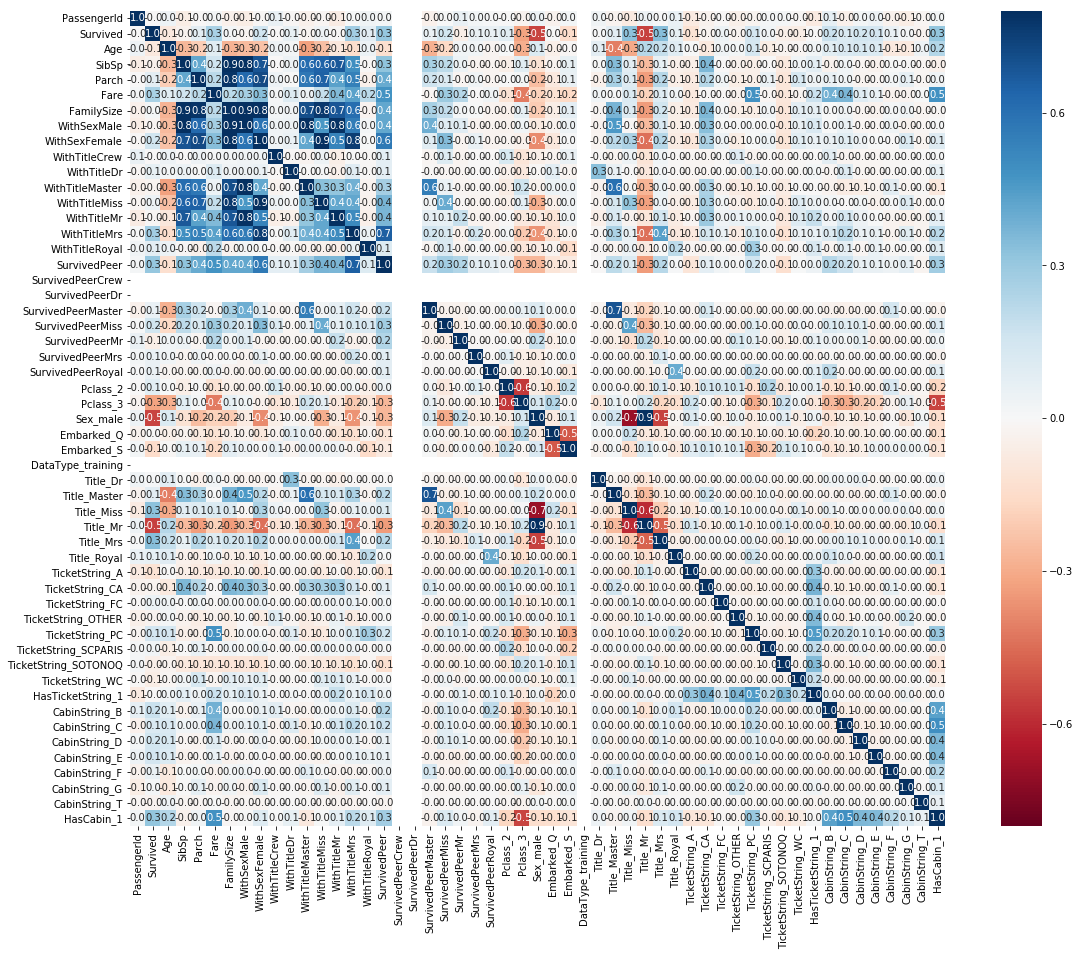

In [46]:
# compute pairwise correlation of columns, excluding NA/null values and present through heat map
corr = df_data[df_data['DataType_training'] == 1].corr()
fig, axes = plt.subplots(figsize=(20, 15))
heatmap = sns.heatmap(corr, annot=True, cmap=plt.cm.RdBu, fmt='.1f', square=True, vmin=-0.8, vmax=0.8)

> **Model, predict and solve the problem**

Now, it is time to feed the features to Machine Learning models.

In [47]:
# select all features to evaluate the feature importances
x = df_data[df_data['DataType_training'] == 1].drop(['PassengerId', 'Survived', 'Name', 'Ticket', 'Cabin', 'Surname', 'FamilySize', 'DataType_training', 'SurvivedPeerCrew', 'SurvivedPeerDr', 'SurvivedPeerMaster', 'SurvivedPeerMiss', 'SurvivedPeerMr', 'SurvivedPeerMrs', 'SurvivedPeerRoyal'], axis=1)
y = df_data.loc[df_data['DataType_training'] == 1, 'Survived']

In [48]:
# set up random forest classifier to find the feature importances
forestclf = RandomForestClassifier(n_estimators=100, random_state=58).fit(x, y)
feat = pd.DataFrame(data=forestclf.feature_importances_, index=x.columns, columns=['FeatureImportances']).sort_values(['FeatureImportances'], ascending=False)

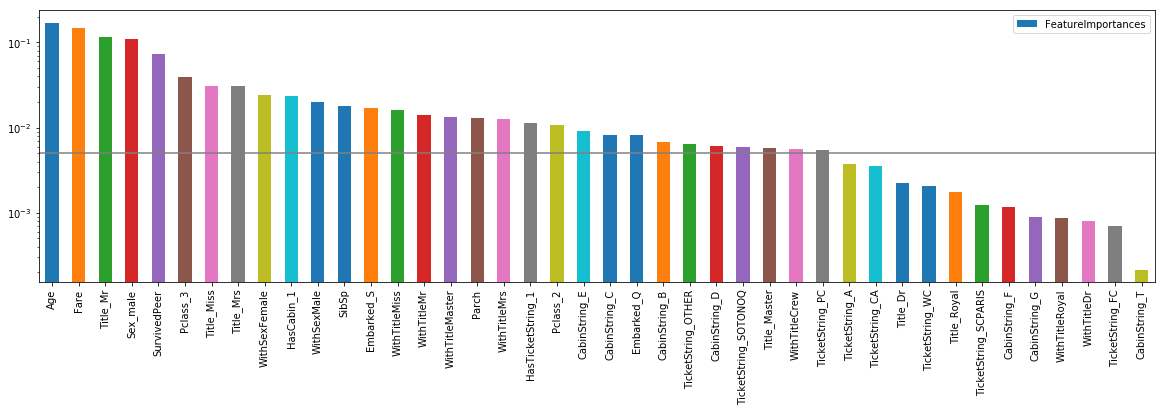

In [49]:
# plot the feature importances
feat.plot(y='FeatureImportances', figsize=(20, 5), kind='bar', logy=True)
plt.axhline(0.005, color="grey")

In [50]:
# list feature importances
model_feat = feat[feat['FeatureImportances'] > 0.005].index

In [51]:
# select the important features
x = df_data.loc[df_data['DataType_training'] == 1, model_feat]
y = df_data.loc[df_data['DataType_training'] == 1, 'Survived']

In [52]:
# perform train-test (validate) split
x_train, x_validate, y_train, y_validate = train_test_split(x, y, test_size=0.25, random_state=58)

In [53]:
# logistic regression model setup
model_logreg = LogisticRegression(solver='lbfgs', max_iter=1024)

# logistic regression model fit
model_logreg.fit(x_train, y_train)

# logistic regression model prediction
model_logreg_ypredict = model_logreg.predict(x_validate)

# logistic regression model metrics
model_logreg_f1score = f1_score(y_validate, model_logreg_ypredict)
model_logreg_accuracyscore = accuracy_score(y_validate, model_logreg_ypredict)
model_logreg_cvscores = cross_val_score(model_logreg, x, y, cv=20, scoring='accuracy')
print('logistic regression\n  f1 score: %0.4f, accuracy score: %0.4f, cross validation score: %0.4f (+/- %0.4f)' %(model_logreg_f1score, model_logreg_accuracyscore, model_logreg_cvscores.mean(), 2 * model_logreg_cvscores.std()))

logistic regression
  f1 score: 0.8046, accuracy score: 0.8475, cross validation score: 0.8271 (+/- 0.1019)


In [54]:
# decision tree classifier model setup
model_treeclf = DecisionTreeClassifier(splitter='best', min_samples_split=5)

# decision tree classifier model fit
model_treeclf.fit(x_train, y_train)

# decision tree classifier model prediction
model_treeclf_ypredict = model_treeclf.predict(x_validate)

# decision tree classifier model metrics
model_treeclf_f1score = f1_score(y_validate, model_treeclf_ypredict)
model_treeclf_accuracyscore = accuracy_score(y_validate, model_treeclf_ypredict)
model_treeclf_cvscores = cross_val_score(model_treeclf, x, y, cv=20, scoring='accuracy')
print('decision tree classifier\n  f1 score: %0.4f, accuracy score: %0.4f, cross validation score: %0.4f (+/- %0.4f)' %(model_treeclf_f1score, model_treeclf_accuracyscore, model_treeclf_cvscores.mean(), 2 * model_treeclf_cvscores.std()))

decision tree classifier
  f1 score: 0.8087, accuracy score: 0.8430, cross validation score: 0.8049 (+/- 0.1394)


In [55]:
# random forest classifier model setup
model_forestclf = RandomForestClassifier(n_estimators=100, min_samples_split=5, random_state=58)

# random forest classifier model fit
model_forestclf.fit(x_train, y_train)

# random forest classifier model prediction
model_forestclf_ypredict = model_forestclf.predict(x_validate)

# random forest classifier model metrics
model_forestclf_f1score = f1_score(y_validate, model_forestclf_ypredict)
model_forestclf_accuracyscore = accuracy_score(y_validate, model_forestclf_ypredict)
model_forestclf_cvscores = cross_val_score(model_forestclf, x, y, cv=20, scoring='accuracy')
print('random forest classifier\n  f1 score: %0.4f, accuracy score: %0.4f, cross validation score: %0.4f (+/- %0.4f)' %(model_forestclf_f1score, model_forestclf_accuracyscore, model_forestclf_cvscores.mean(), 2 * model_forestclf_cvscores.std()))

random forest classifier
  f1 score: 0.8072, accuracy score: 0.8565, cross validation score: 0.8463 (+/- 0.1178)


In [56]:
# specify the hyperparameter space
params = {'n_estimators': [100],
          'max_depth': [10, 20, None],
          'min_samples_split': [3, 5, 7, 9],
          'random_state': [58],
}

# random forest classifier grid search model setup
model_forestclf_cv = GridSearchCV(model_forestclf, params, cv=5)

# random forest classifier grid search model fit
model_forestclf_cv.fit(x_train, y_train)

# random forest classifier grid search model prediction
model_forestclf_cv_ypredict = model_forestclf_cv.predict(x_validate)

# random forest classifier grid search model metrics
model_forestclf_cv_f1score = f1_score(y_validate, model_forestclf_cv_ypredict)
model_forestclf_cv_accuracyscore = accuracy_score(y_validate, model_forestclf_cv_ypredict)
model_forestclf_cv_cvscores = cross_val_score(model_forestclf_cv, x, y, cv=20, scoring='accuracy')
print('random forest classifier grid search\n  f1 score: %0.4f, accuracy score: %0.4f, cross validation score: %0.4f (+/- %0.4f)' %(model_forestclf_cv_f1score, model_forestclf_cv_accuracyscore, model_forestclf_cv_cvscores.mean(), 2 * model_forestclf_cv_cvscores.std()))
print('  best parameters: %s' %model_forestclf_cv.best_params_)

random forest classifier grid search
  f1 score: 0.8095, accuracy score: 0.8565, cross validation score: 0.8395 (+/- 0.1202)
  best parameters: {'max_depth': 10, 'min_samples_split': 7, 'n_estimators': 100, 'random_state': 58}


> **Supply or submit the results**

Our submission to the competition site Kaggle is ready. Any suggestions to improve our score are welcome.

In [57]:
# model selection
final_model = model_forestclf

# prepare testing data and compute the observed value
x_test = df_data.loc[df_data['DataType_training'] == 0, model_feat]
y_test = pd.DataFrame(final_model.predict(x_test), columns=['Survived'], index=df_data.loc[df_data['DataType_training'] == 0, 'PassengerId'])

In [58]:
# submit the results
out = pd.DataFrame({'PassengerId': y_test.index, 'Survived': y_test['Survived']})
out.to_csv('submission.csv', index=False)